### Preparacion Entorno


In [1]:
#!pip install beautifulsoup4
#!pip install nltk
#!pip install scikit-learn
#!pip install torch
#!pip install spacy
!nvidia-smi



Sat Oct 28 01:47:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:68:00.0 Off |                  N/A |
| 51%   80C    P0   153W / 250W |      0MiB / 10989MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#!pip install --upgrade pip
#!pip install --upgrade pydantic spacy
#!python -m spacy download en

In [3]:
import time
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


# Global device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Semillas
seed = 127


import numpy as np

np.random.seed(seed)

import tensorflow as tf

tf.random.set_seed(seed)

import torch

torch.manual_seed(seed)

### Exploracion de Datos


In [5]:
# Carga el conjunto de datos de entrenamiento
all_train_data = pd.read_csv("train_set.csv")
test_data = pd.read_csv("test_set.csv")

# Visualiza las primeras filas del conjunto de entrenamiento
print(all_train_data.head())

                                       question_text  target
0  How are the new internet privacy rules going t...       0
1  What are the diagnostic features of suffering ...       0
2               What is the soundtrack to your life?       0
3        What is the best phone under 6000 in India?       0
4  Why is 200 year old music box an early compute...       0


##### Distribucion de Clases


0    258592
1     64648
Name: target, dtype: int64


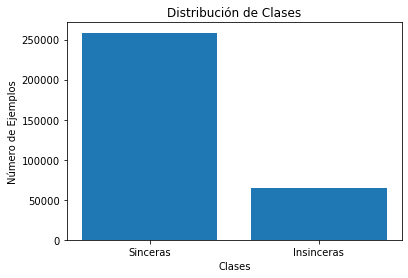

In [6]:
class_distribution = all_train_data["target"].value_counts()
print(class_distribution)


import matplotlib.pyplot as plt

plt.bar(class_distribution.index, class_distribution.values)
plt.xticks(class_distribution.index, ["Sinceras", "Insinceras"])
plt.xlabel("Clases")
plt.ylabel("Número de Ejemplos")
plt.title("Distribución de Clases")
plt.show()

##### Longitud de Preguntas


In [7]:
question_lengths = all_train_data["question_text"].apply(lambda x: len(x.split()))
print(question_lengths.describe())

count    323240.000000
mean         13.443228
std           7.628281
min           1.000000
25%           8.000000
50%          11.000000
75%          16.000000
max          64.000000
Name: question_text, dtype: float64


##### Exploracion pregunts Insinceras y Sinceras


In [8]:
print("Insincere")
insincere_questions = all_train_data[all_train_data["target"] == 1]
for i in range(5):  # Imprime las primeras 5 preguntas insinceras
    print(insincere_questions.iloc[i]["question_text"])
print("")
print("Sincere")

sincere_questions = all_train_data[all_train_data["target"] == 0]
for i in range(5):  # Imprime las primeras 5 preguntas sinceras
    print(sincere_questions.iloc[i]["question_text"])

Insincere
Why does white culture appear more civilized than other cultures historically?
Why are some polish people so rude and never smile?
Why does each and every Kannadiga from Mysore - Bangalore region in Karnataka hate Mangalore and its people?
Why is the BJP leadership quiet about conduct of its MLAs and ministers, in case of the treatment meted out to rape victims and their families in Unnao and Kathua?
Why did Modi led BJP Government allowing illegal Rohingya Muslims to settle in Jammu which is a very sensitive area?

Sincere
How are the new internet privacy rules going to affect the Americans living in the USA?
What are the diagnostic features of suffering from groin and back pain simultaneously?
What is the soundtrack to your life?
What is the best phone under 6000 in India?
Why is 200 year old music box an early computer, complete with social media?


In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image


def generate_wordcloud(data, mask_file=None, transform_mask=False):
    if mask_file is None:
        wordcloud = WordCloud(
            background_color="white",
            random_state=40,
            mode="RGB",
            min_font_size=6,
            max_words=150,
            width=300,
            height=300,
        )
        wordcloud.generate(data)
        plt.figure(figsize=[10, 10])
        plt.imshow(wordcloud, interpolation="bilinear")
    else:
        mask = np.array(Image.open(mask_file))
        image_colors = ImageColorGenerator(mask)
        wordcloud = WordCloud(
            background_color="white",
            max_words=150,
            max_font_size=50,
            random_state=40,
            mask=mask,
            width=300,
            height=300,
        )
        wordcloud.generate(data)
        plt.imshow(
            wordcloud.recolor(3, color_func=image_colors),
            cmap=plt.cm.white,
            interpolation="bilinear",
        )
    plt.axis("off")
    plt.show()

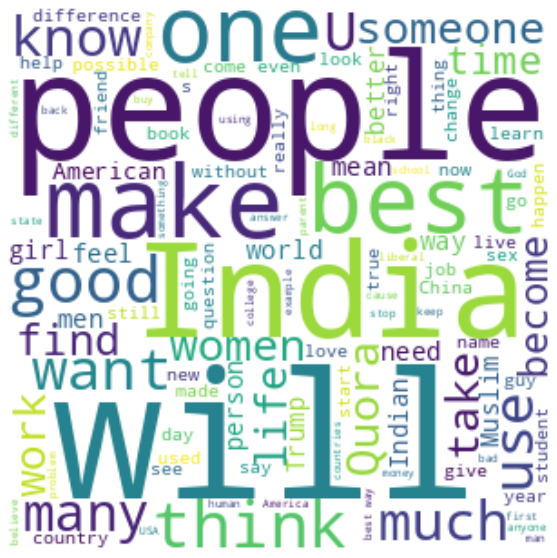

In [10]:
all_words = " ".join(list(all_train_data["question_text"]))

generate_wordcloud(all_words)

##### Preguntas insinceras


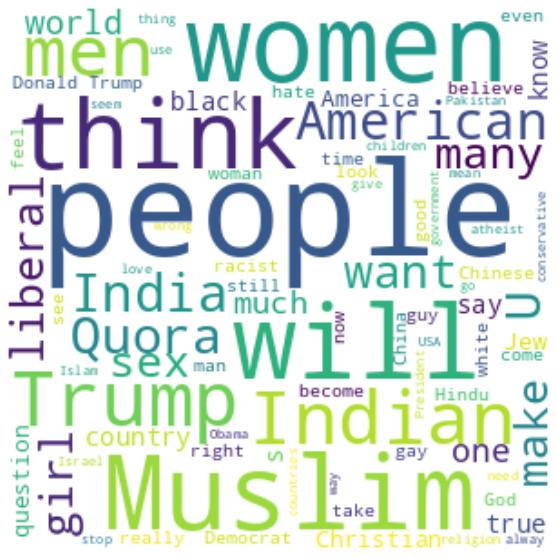

In [11]:
ds_insincere = all_train_data[all_train_data.target == 1]
ds_sincere = all_train_data[all_train_data.target == 0]

words = " ".join(list(ds_insincere["question_text"]))

generate_wordcloud(words)

##### Preguntas Sinceras


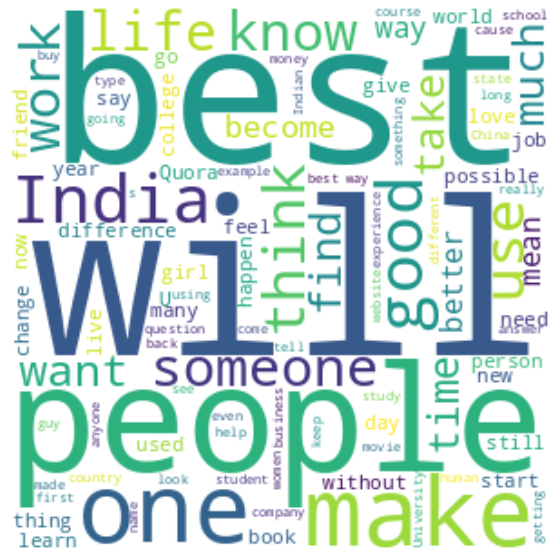

In [12]:
sincere_words = " ".join(list(ds_sincere["question_text"]))

generate_wordcloud(sincere_words)

Preguntas Sinceras, parecen mas orientadas a consejos (best, know , way, good, make) sin mucho clasificativo o comentario polemico/racista

Mientras que las preguntas Insisnceras usan mayoritariamente palabras cuestionables, calificativos, y giran en torno a temas politicos (paises, presidentes, etnias)


Tenemos una distribucion de clases desequilibrada

La longitud media de las preguntas es de 13 palabras y la maxima de 64 (buen dato para determinar la longitud maxima de secuencia al tokenizar las preguntas)


### Preprocesamiento de Texto


##### Embeddings


In [13]:
# Descargo embedding previamente:

#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [14]:
import numpy as np


# Cargar los embeddings pre-entrenados (cambia el archivo a tu ubicación)
def load_pretrained_embeddings(filename):
    embeddings_index = {}
    with open(filename, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    return embeddings_index


# Ruta al archivo de embeddings pre-entrenados
embeddings_file = "glove.6B.100d.txt"
embeddings_index = load_pretrained_embeddings(embeddings_file)

##### Preprocesamiento


In [15]:
import re
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

# Definir la longitud máxima
max_sequence_length = 64


# Tokenización y preprocesamiento de texto
def preprocess_text(text, embeddings_index):
    # Convierte a minúsculas
    text = text.lower()
    # Tokenización
    tokens = re.findall(r"\b\w+\b", text)
    # Filtra palabras que no están en los embeddings
    tokens = [word for word in tokens if word in embeddings_index]
    return tokens


# Aplicar preprocesamiento a las preguntas en all_train_data
all_train_data["tokens"] = all_train_data["question_text"].apply(
    lambda x: preprocess_text(x, embeddings_index)
)

# Crear un vocabulario (incluyendo el token de relleno)
vocab = set(embeddings_index.keys())
vocab.add("<PAD>")  # Agrega el token de relleno al vocabulario
vocab_size = len(vocab)

# Crear un diccionario que asocie palabras con índices
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}


# Convertir tokens a secuencias de índices
def tokens_to_indices(tokens):
    return torch.LongTensor(
        [word_to_idx[word] for word in tokens if word in word_to_idx]
    )


all_train_data["indices"] = all_train_data["tokens"].apply(tokens_to_indices)

# Convierte la columna 'indices' en una lista de tensores
sequences = all_train_data["indices"].tolist()
# Padding de secuencias para que tengan la misma longitud
tokenized_sequences = pad_sequence(sequences, batch_first=True)

# Ahora `tokenized_sequences` es un tensor de PyTorch con las secuencias de índices
# que puedes usar para entrenar tu RNN.

print("Vocabulario size:", vocab_size)
print("Ejemplo de secuencia de índices:", tokenized_sequences[0])

Vocabulario size: 400001
Ejemplo de secuencia de índices: tensor([303469, 136191,  51699,  33527,  46599, 117985, 178207, 392558, 198377,
        174825,  51699, 319633, 326834, 163343,  51699, 380311,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0

In [16]:
#!pip install --upgrade imbalanced-learn scikit-learn

##### Separacion train y validation datasets


In [29]:
# ver de hacer stratify de split sklearn


# pip install -U imbalanced-learn
#!pip install imbalanced-learn==0.7.0
from sklearn.model_selection import train_test_split


# Define la proporción de datos que se utilizarán para validación
validation_size = 0.2  # Por ejemplo, 20% para validación

# Divide tus datos en conjuntos de entrenamiento y validación
(
    train_sequences,
    validation_sequences,
    train_labels,
    validation_labels,
) = train_test_split(
    tokenized_sequences,
    all_train_data["target"].values,
    test_size=validation_size,
    random_state=seed,
    stratify=all_train_data["target"].values,
)

#### Para el Desbalance de Clases aplico posweights


In [28]:
# Calculo para mejorar
from torch.utils.data import DataLoader, TensorDataset
import sklearn
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Convierte train_labels a un tensor de PyTorch
train_labels = torch.FloatTensor(train_labels)


# Define una función para calcular los pesos de clase
def calculate_class_weights(labels):
    class_counts = labels.type(torch.int32).bincount()
    total_samples = len(labels)
    class_weights = total_samples / (
        2 * class_counts.to(torch.float32)
    )  # Asegurarse de que los cálculos se realicen con 'Float'
    return class_weights


# Calcular los pesos de clase para tus datos de entrenamiento
class_weights = calculate_class_weights(train_labels)
class_weights[1]  # el peso para mi clase positiva (respuestas insinceras)

tensor(2.5000)

### Seleccion de Modelo Y Entrenamiento


#### Arquitectura Modelo


In [30]:
import torch
import torch.nn as nn

# Obtener la matriz de embeddings desde el diccionario     ---> FREEZARLO (PARA NO CATASTROFIC FORGETING)
embeddings_matrix = torch.tensor(list(embeddings_index.values()))


# Define una clase para el modelo
class RNNModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout,
    ):
        super(RNNModel, self).__init__()

        # Capa de embedding con los embeddings pre-entrenados (la congele)
        self.embedding = nn.Embedding.from_pretrained(embeddings_matrix, freeze=True)

        # Capa RNN (LSTM en este caso)
        self.rnn = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )

        # Añade el atributo bidirectional
        self.bidirectional = bidirectional

        # Capa lineal de salida
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1)

        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # text: secuencias de índices
        # text_lengths: longitud real de cada secuencia
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths, batch_first=True
        )
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        hidden = self.dropout(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
            if self.bidirectional
            else hidden[-1, :, :]
        )
        output = self.fc(hidden)
        return output


# Definir hiperparámetros
vocab_size = len(vocab)  # Tamaño del vocabulario
embedding_dim = 100  # Dimensión de los embeddings    # Es la dimension de los embeddings preentrenados
hidden_dim = 120  # Dimensión de la capa oculta de la RNN
output_dim = 1  # Dimensión de la capa de salida (en el caso de clasificación binaria)
n_layers = 2  # Número de capas RNN
bidirectional = True  # RNN bidireccional
dropout = 0.4  # Probabilidad de dropout

# Crear una instancia del modelo
model = RNNModel(
    vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout
)
model = model.to(device)

# Imprimir el modelo
print(model)

RNNModel(
  (embedding): Embedding(400000, 100)
  (rnn): LSTM(100, 120, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=240, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


##### Dataloaders para el entrenamiento


In [19]:
from torch.utils.data import DataLoader, TensorDataset

# Crear tensores PyTorch para los datos de entrenamiento y validación
train_sequences = torch.LongTensor(train_sequences)  # Convierte a tensores de PyTorch
train_labels = torch.FloatTensor(train_labels)

validation_sequences = torch.LongTensor(validation_sequences)
validation_labels = torch.FloatTensor(validation_labels)

# Crear conjuntos de datos de PyTorch
train_dataset = TensorDataset(train_sequences, train_labels)
validation_dataset = TensorDataset(validation_sequences, validation_labels)

# Definir el tamaño del lote
batch_size = 32

# Crear dataloaders
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2
)
validation_dataloader = DataLoader(
    validation_dataset, batch_size=batch_size, pin_memory=True, num_workers=2
)

##### Aplicacion Modelo y Calculo de Metricas


In [20]:
import sklearn
from sklearn.metrics import f1_score, recall_score, accuracy_score

# Definir hiperparámetros
num_epochs = 10
learning_rate = 0.001

# Definir la función de pérdida
pos_weight = torch.tensor([2.5000], device=device)  # Peso para la clase positiva
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lista para almacenar las métricas durante el entrenamiento
train_f1_scores = []
train_accuracy_scores = []
train_recall_scores = []
train_loss_scores = []


# Lista para almacenar las métricas durante la validación
validation_f1_scores = []
validation_accuracy_scores = []
validation_recall_scores = []
validation_loss_scores = []


for epoch in range(num_epochs):
    # Establecer el modelo en modo de entrenamiento
    model.train()
    total_loss = 0

    # Inicializar métricas de entrenamiento
    train_outputs, train_true_labels = [], []

    for batch_idx, batch in enumerate(train_dataloader):
        inputs, labels = batch

        # Mueve los datos al mismo dispositivo que el modelo
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reiniciar los gradientes
        text_lengths = [len(seq) for seq in inputs]
        outputs = model(inputs, text_lengths)  # Propagación hacia adelante
        outputs = outputs.squeeze()

        labels = labels.type_as(outputs)
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Retropropagación del error
        optimizer.step()  # Actualizar pesos
        total_loss += loss.item()

        # Registra las predicciones y etiquetas verdaderas en el conjunto de entrenamiento
        train_outputs.extend(outputs.detach().cpu().numpy())
        train_true_labels.extend(labels.detach().cpu().numpy())

    # Calcula las métricas de entrenamiento
    train_predictions = (np.array(train_outputs) > 0.5).astype(int)
    train_f1 = f1_score(train_true_labels, train_predictions)
    train_recall = recall_score(train_true_labels, train_predictions)
    train_accuracy = accuracy_score(train_true_labels, train_predictions)

    # Ahora puedes imprimir las métricas de entrenamiento
    print(
        f"Época {epoch + 1}/{num_epochs}, Loss(train): {total_loss:.4f}, F1(train): {train_f1:.4f}, Recall(train): {train_recall:.4f}, Accuracy(train): {train_accuracy:.4f}"
    )

    # Almacenar métricas de entrenamiento en las listas
    train_f1_scores.append(train_f1)
    train_accuracy_scores.append(train_accuracy)
    train_recall_scores.append(train_recall)
    train_loss_scores.append(total_loss)

    # Evaluación en datos de validación
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch_idx, batch in enumerate(validation_dataloader):
            inputs, labels = batch
            text_lengths = [
                len(seq) for seq in inputs
            ]  # Calcula las longitudes de secuencias en cada lote

            # Mueve los datos al mismo dispositivo que el modelo
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, text_lengths)
            outputs = outputs.squeeze()
            # Convierte las etiquetas a tipo float para que coincidan con las salidas
            labels = labels.type_as(outputs)

            predicted = (
                outputs > 0.5
            ).float()  # Aplicar un umbral para obtener las predicciones binarias
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)  # Calcular la pérdida
            total_loss += loss.item()

    # Calcular métricas de evaluación
    f1 = f1_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)

    print(
        f"Época {epoch + 1}/{num_epochs}, Loss(valid): {total_loss:.4f}, F1(valid): {f1:.4f}, Recall(valid): {recall:.4f}, Accuracy(valid): {accuracy:.4f}"
    )

    # Almacenar métricas de entrenamiento en las listas
    validation_f1_scores.append(f1)
    validation_accuracy_scores.append(accuracy)
    validation_recall_scores.append(recall)
    validation_loss_scores.append(total_loss)

# Encontrar la época con el mejor F1 y su valor
best_epoch = np.argmax(validation_f1_scores)
best_f1 = validation_f1_scores[best_epoch]
print(f"Mejor F1: {best_f1:.4f} en la época {best_epoch + 1}")

Época 1/10, Loss(train): 4309.2837, F1(train): 0.6475, Recall(train): 0.6298, Accuracy(train): 0.8628
Época 1/10, Loss(valid): 945.5578, F1(valid): 0.7078, Recall(valid): 0.7388, Accuracy(valid): 0.8780
Época 2/10, Loss(train): 3558.2848, F1(train): 0.7249, Recall(train): 0.7314, Accuracy(train): 0.8890
Época 2/10, Loss(valid): 874.2747, F1(valid): 0.7297, Recall(valid): 0.7698, Accuracy(valid): 0.8860
Época 3/10, Loss(train): 3227.3662, F1(train): 0.7512, Recall(train): 0.7694, Accuracy(train): 0.8981
Época 3/10, Loss(valid): 826.5020, F1(valid): 0.7456, Recall(valid): 0.7798, Accuracy(valid): 0.8935
Época 4/10, Loss(train): 2953.6355, F1(train): 0.7743, Recall(train): 0.8025, Accuracy(train): 0.9064
Época 4/10, Loss(valid): 823.3819, F1(valid): 0.7463, Recall(valid): 0.7770, Accuracy(valid): 0.8943
Época 5/10, Loss(train): 2707.0110, F1(train): 0.7933, Recall(train): 0.8284, Accuracy(train): 0.9137
Época 5/10, Loss(valid): 842.9519, F1(valid): 0.7477, Recall(valid): 0.7357, Accuracy(

##### Visualizacion de Resultados Train vs Validacion


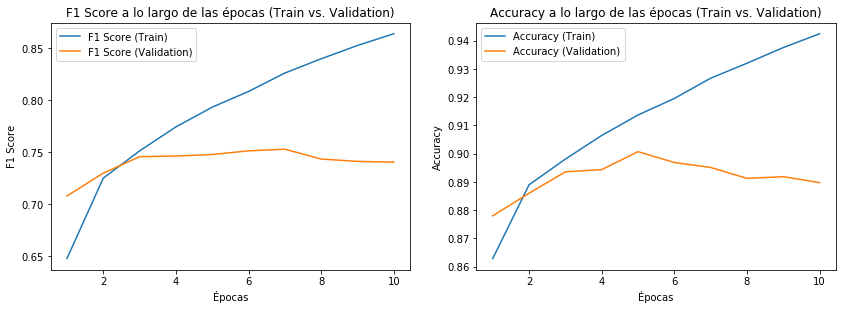

In [24]:
# Visualización de métricas para train y validation
import matplotlib.pyplot as plt

# Listas para almacenar las métricas a lo largo de las épocas
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))

# F1 Score en train y validation
plt.subplot(2, 2, 1)
plt.plot(epochs, train_f1_scores, label="F1 Score (Train)")
plt.plot(epochs, validation_f1_scores, label="F1 Score (Validation)")
plt.xlabel("Épocas")
plt.ylabel("F1 Score")
plt.legend()
plt.title("F1 Score a lo largo de las épocas (Train vs. Validation)")

# Accuracy en train y validation
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy_scores, label="Accuracy (Train)")
plt.plot(epochs, validation_accuracy_scores, label="Accuracy (Validation)")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy a lo largo de las épocas (Train vs. Validation)")

plt.tight_layout()
plt.show()

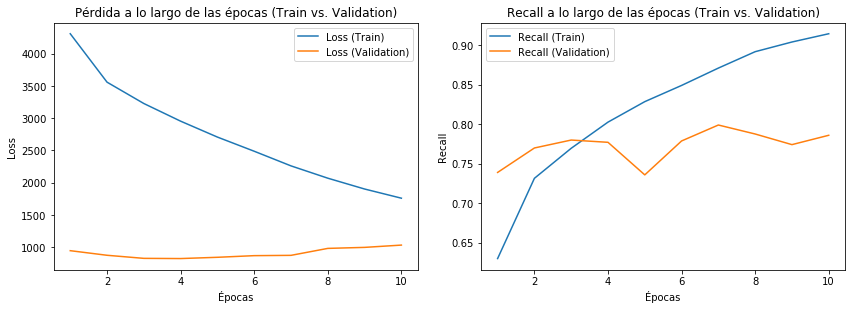

In [25]:
plt.figure(figsize=(12, 8))

# Pérdida en train y validation
plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss_scores, label="Loss (Train)")
plt.plot(epochs, validation_loss_scores, label="Loss (Validation)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.title("Pérdida a lo largo de las épocas (Train vs. Validation)")

# Recall en train y validation
plt.subplot(2, 2, 4)
plt.plot(epochs, train_recall_scores, label="Recall (Train)")
plt.plot(epochs, validation_recall_scores, label="Recall (Validation)")
plt.xlabel("Épocas")
plt.ylabel("Recall")
plt.legend()
plt.title("Recall a lo largo de las épocas (Train vs. Validation)")

plt.tight_layout()
plt.show()

### Evaluacion Metricas en Test


In [26]:
# Paso 1: Preprocesamiento de datos de prueba
test_data["tokens"] = test_data["question_text"].apply(
    lambda x: preprocess_text(x, embeddings_index)
)
test_data["indices"] = test_data["tokens"].apply(tokens_to_indices)
test_sequences = test_data["indices"].tolist()
tokenized_test_sequences = pad_sequence(test_sequences, batch_first=True)

# Paso 2: Creación de DataLoader para datos de prueba
test_sequences = torch.LongTensor(tokenized_test_sequences)
test_dataset = TensorDataset(test_sequences)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, pin_memory=True, num_workers=2
)

# Paso 4: Realizar predicciones
model.eval()
predictions = []

with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        inputs = batch[0].to(device)
        text_lengths = [len(seq) for seq in inputs]
        outputs = model(inputs, text_lengths)
        outputs = outputs.squeeze()
        predicted = (outputs > 0.5).float()
        predictions.extend(predicted.cpu().numpy())

# Paso 5: Evaluación de métricas
test_labels = test_data["target"].values
test_predictions = (np.array(predictions) > 0.5).astype(int)
test_f1 = f1_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"F1 en conjunto de prueba: {test_f1:.4f}")
print(f"Recall en conjunto de prueba: {test_recall:.4f}")
print(f"Accuracy en conjunto de prueba: {test_accuracy:.4f}")

F1 en conjunto de prueba: 0.7442
Recall en conjunto de prueba: 0.7937
Accuracy en conjunto de prueba: 0.8909
